In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir
    lk.search.sr_cache.expire_seconds = 86400

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

In [2]:
import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions

from types import SimpleNamespace  # to adapt LightCurve object to the structure exepcted by etv_functions

# TIC 99654378, potential mult-planet system with TTVs

In [3]:
tic = 99654378

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = sr[np.isin(sr.author, ["SPOC", "TESS-SPOC", "QLP"])]  # to remove DIMANTE lc
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 26,2020,TESS-SPOC,1800,99654378,0.0,N/A
1,TESS Sector 40,2021,TESS-SPOC,600,99654378,0.0,N/A
2,TESS Sector 47,2021,TESS-SPOC,600,99654378,0.0,N/A
3,TESS Sector 53,2022,TESS-SPOC,600,99654378,0.0,N/A
4,TESS Sector 60,2022,SPOC,120,99654378,0.0,N/A
5,TESS Sector 74,2024,SPOC,120,99654378,0.0,N/A


LightCurveCollection of 6 objects:
    0: <TessLightCurve LABEL="TIC 99654378" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 99654378" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 99654378" SECTOR=47 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 99654378" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 99654378" SECTOR=60 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 99654378" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

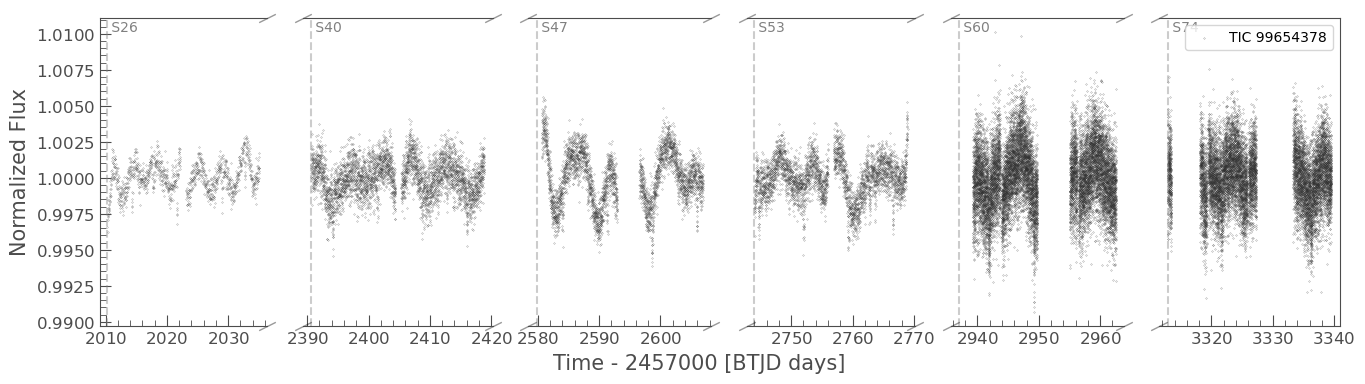

In [4]:
lc = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.normalize())
axs = tplt.plot_skip_data_gap(lc, s=0.1);

In [5]:
# The initial tranist parameters 
transit_specs = TransitTimeSpecList(  # TIC 99654378, TOI .01 and possibly more
    dict(epoch=2598.6553460, duration_hr=3.3584932, period=7.3034530 , label="pl 1", transit_depth_percent=0.1563,  # Pyaneti fit from TESS-SPOC 10min sectors
        # epoch=2598.6592, duration_hr=3.2180, period=7.303959, label="TOI 5182.01", transit_depth_percent=0.2050,  # TOI value
         sector=47, steps_to_show=[0,  1],  # -1,  -2
        ),
    dict(epoch=2018.0336720, period=14.6207858, duration_hr=5.237, label="pl 2", transit_depth_percent=0.1064,  # Pyaneti fit from TESS-SPOC 10min sectors (duration_hr from zoo3hans)
         # epoch=(2017.928620+2018.146814)/2, period=14.6207, duration_hr=5.237, label="pl 2", transit_depth_percent=0.1272,  # from zoo3hans
         sector=26, steps_to_show=[1,  0],  # step 0 close to pl 3
    ),
    dict(epoch=(2017.611356+2017.903022)/2, period=745.037949, duration_hr=7.0, label="pl 3", transit_depth_percent=0.2220,
         sector=26, steps_to_show=[0],
         # sector=53, steps_to_show=[1],  # step 1 in S53
    ),
    dict(epoch=(3320.920022+3321.107522)/2, period=9999.9, duration_hr=4.5, label="pl 4", transit_depth_percent=0.2035,
         sector=74, steps_to_show=[0],
    ),
    defaults=dict(surround_time=0.5)
)


## TTV for `pl 1` / TOI 5182.01

6


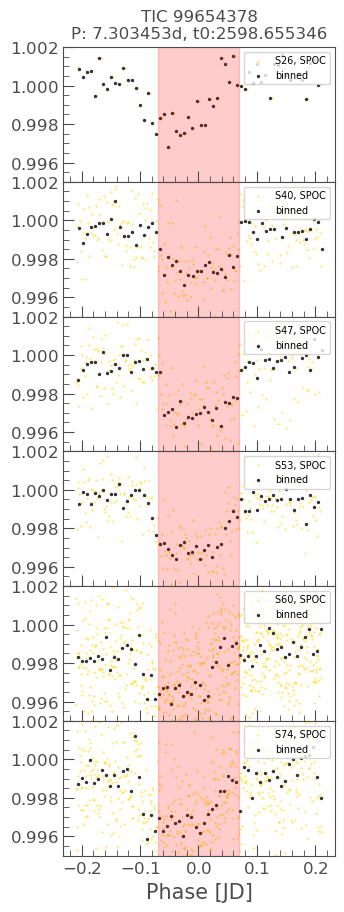

In [29]:
# The period from Pyaneti seems to be solid except TTV, so I use it as-is
a_spec = transit_specs[0]

# fold each sector's data, and attempt to find the best-fit t0 in each sector
lc_f_c = []
for lc in lcc_tess:
    lc_f = lc.normalize().fold(
        period=a_spec['period'], 
        # period=7.303359540336835,  # from MCMC period fit of all data (high stdv)
        epoch_time=a_spec['epoch'],
    )
    lc_f.label = f"S{lc_f.sector}, {lc_f.author}"
    lc_f_c.append(lc_f)
print(len(lc_f_c))


with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(len(lc_f_c), 1, sharex=True, squeeze=True, figsize=(3.5, 1.75 * len(lc_f_c)));
    fig.subplots_adjust(wspace=0, hspace=0)

for i, lc_f  in enumerate(of_sectors(lc_f_c[:],)):
    ax = axs[i]

    lc_f = lc_f.truncate(0 - a_spec['duration_hr'] / 24 * 1.5, 0 + a_spec['duration_hr'] / 24 * 1.5)
    ax = lc_f.scatter(ax=ax, s=0.5, c="gold")

    lc_f_b = lke.bin_flux(lc_f, time_bin_size=10*u.min)
    ax = lc_f_b.scatter(ax=ax, s=2, marker="o", label="binned")
    
    ax.legend(loc="upper right", fontsize="x-small");
    ax.set_ylim(0.995, 1.002);  # consistent y-scale
    
    ax.axvspan(0 - a_spec['duration_hr'] / 24 * 0.5, 0 + a_spec['duration_hr'] / 24 * 0.5, color="red", alpha=0.2);
    if lc_f is not lc_f_c[-1]:
        ax.set_ylabel(None)
axs[0].set_title(f"{lcc_tess[0].label}\nP: {a_spec['period']}d, t0:{a_spec['epoch']}");

In [7]:
# Guess MCMC initial values, using S40, 47, 53 (relatively close)

lc_f = lke.stitch(of_sectors(lcc_tess, 40, 47, 53)).fold(period=a_spec['period'], epoch_time=a_spec['epoch'])
lc_f = lc_f.truncate(0 - a_spec['duration_hr'] / 24 * 0.9, 0 + a_spec['duration_hr'] / 24 * 0.9)
print("len(lc_f):", len(lc_f))
# lc_f.scatter();

lc_f_b = lc_f.bin(time_bin_size=5*u.min)
# ax2 = lc_f_b.scatter(ax=ax2, label="binned")
print("len(lc_f_b):", len(lc_f_b))

# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.0, -0.003, 0.0, 0.04, 5.0]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, lc_f_b.time.value, lc_f_b.flux.value, lc_f_b.flux_err.value, "t0_phase_pl1", *start_vals)
# etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "t0_phase_pl1", *start_vals)

len(lc_f): 436
len(lc_f_b): 73


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

### Attempt to get a period that fits *all* data, including outliers in sectors 26, 74

- outliers with respect to the current epoch, period
- Use MCMC with a cosh mmdel to fit all dips

100%|████████████████████████████████████████████████████████| 10000/10000 [05:04<00:00, 32.89it/s]


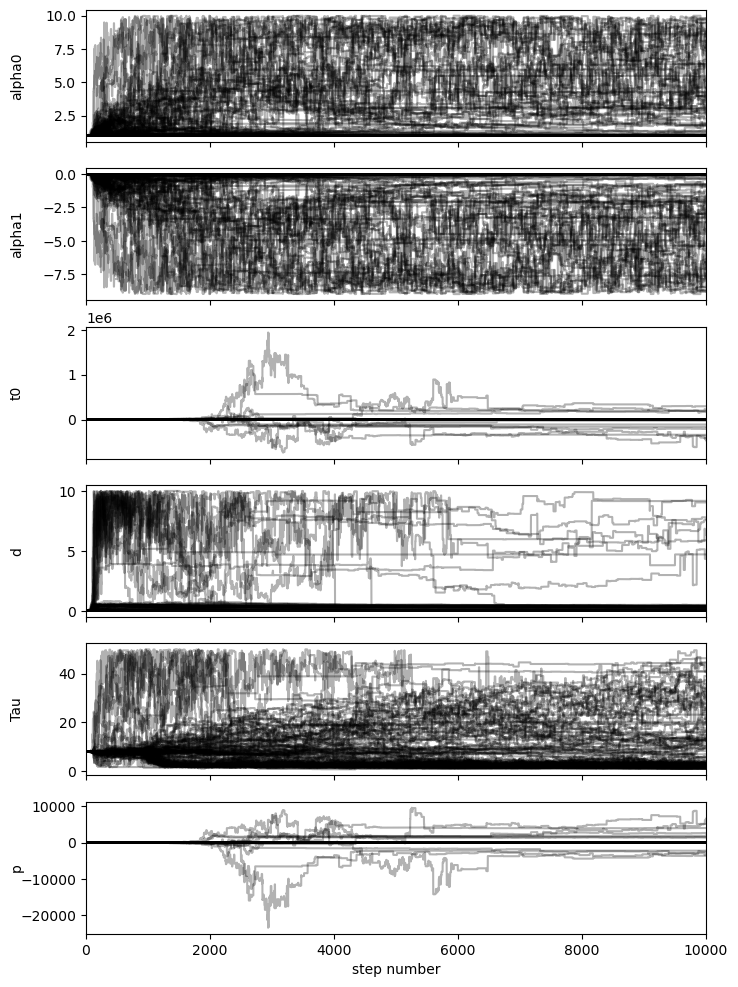

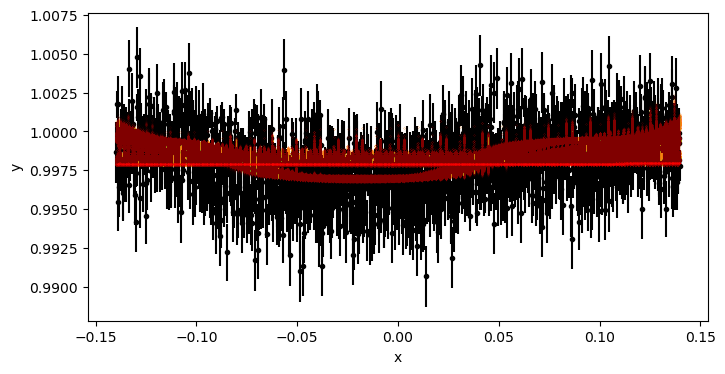

(1.013254213683243, -0.015327442084282734, 2598.643652077001, 0.03830261604448527, 3.298081137258249, 7.303353640669494, {'std_alpha0': 2.6453031880547484, 'std_alpha1': 2.6449880911034, 'std_t0': 75554.44154722647, 'std_d': 1.635906244533941, 'std_Tau': 12.156775087048079, 'std_p': 1000.407071152185})
p: 7.303353640669494 , std_p:  1000.407071152185


In [21]:
lc_all_f = lke.stitch(lcc_tess).fold(period=a_spec['period'], epoch_time=a_spec['epoch']).remove_nans()
lc_all_f = lc_all_f.truncate(0 - a_spec['duration_hr'] / 24 * 1.0, 0 + a_spec['duration_hr'] / 24 * 1.0)

# convert lc to the form needed by fit etv_functions
lc_all_f_data = SimpleNamespace(time=lc_all_f.time_original.value, phase=lc_all_f.time.value, flux=np.array(lc_all_f.flux.value), err=np.array(lc_all_f.flux_err.value))
                                                                                                                               

fit_period_results = etvp.run_mcmc_initial_fit_p(
    lc_all_f_data, 
    # for period fit, t0 is in BTJD rather than phase
    [0.9995624898354846, -0.0025165058269755423, a_spec['epoch'], 0.03361431393736482, 7.979925777082498, a_spec['period'] ],
    nruns=10000, discard=9000,
    # nruns=1000, discard=600,
    # nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_stats = fit_period_results
print(fit_period_results)
print("p:", mean_p, ", std_p: ", fit_params_stats['std_p'])

In [13]:
a_spec['period']

7.303453

### Proceed, ignoring period from MCMC fit of all data

- The period from MCMC fit of all data is not well (the value does not converge), so it's discarded.
- Proceed with the original epoch/period based on S40, 47, 53 (relatively close) TESS-SPOC 10min data

100%|█████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 116.84it/s]


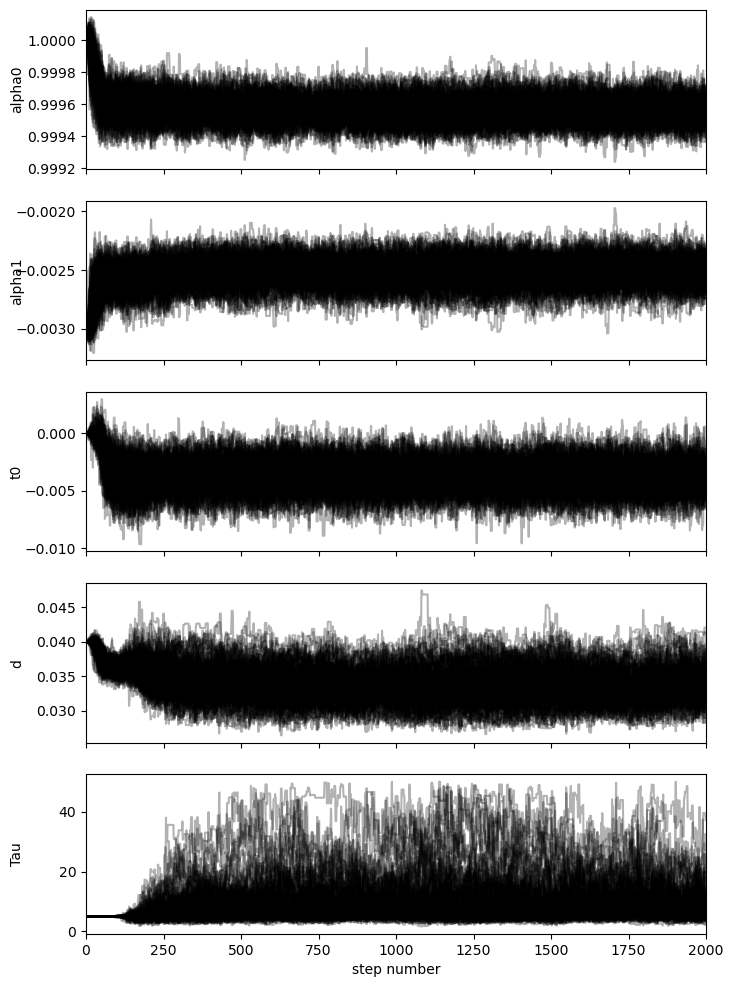

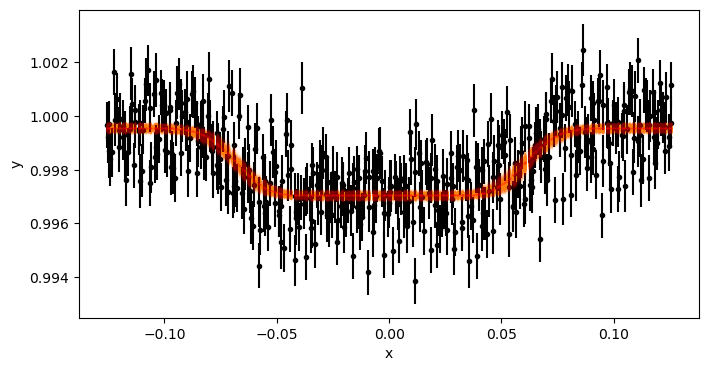

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau= 0.9995624898354846, -0.0025165058269755423, -0.003789120237186875, 0.03361431393736482, 7.979925777082498
std_values: {'std_alpha0': 7.715489328227092e-05, 'std_alpha1': 0.00011353562498274217, 'std_t0': 0.0013356427703132986, 'std_d': 0.002477427728223523, 'std_Tau': 6.098610169226881}


In [34]:
# Get initial model params for subsequent fit
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats  = etv_functions.run_mcmc_initial_fit(
    lc_f_data, 
    [1.0, -0.003, 0.0, 0.04, 5.0],
    nruns=2000, discard=1500,
    # nruns=1000, discard=600,
    nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

# mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau= 0.9995624898354846, -0.0025165058269755423, -0.003789120237186875, 0.03361431393736482, 7.979925777082498
print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau= " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
print("std_values:", fit_params_stats)

100%|█████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 141.87it/s]


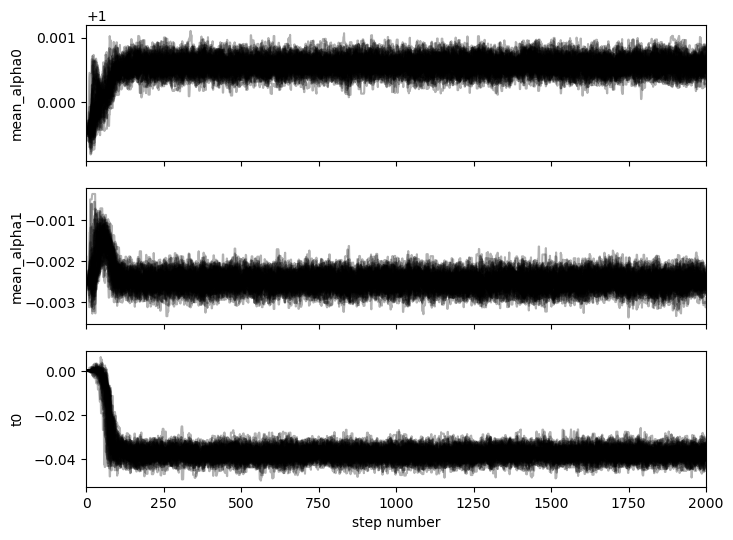

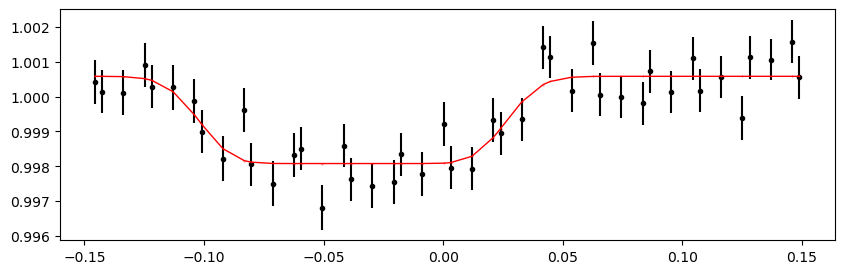

[26, 1.0005802015325207, -0.002501358667439578, -0.03780408843271518, 0.0028637795554439316]


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 132.71it/s]


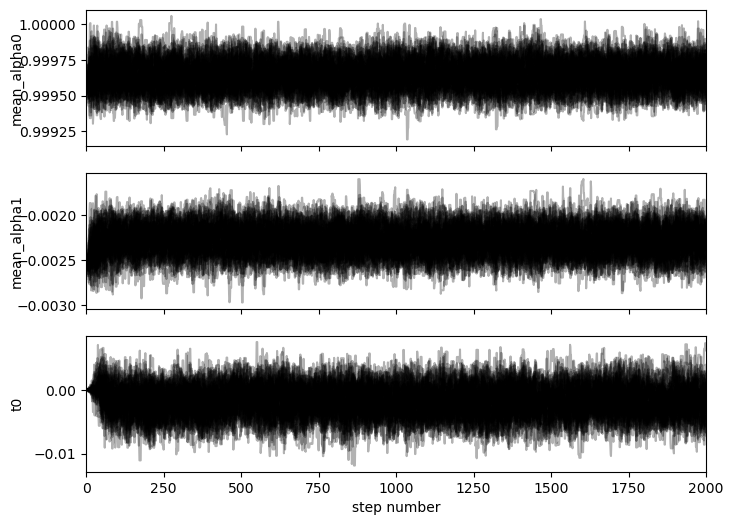

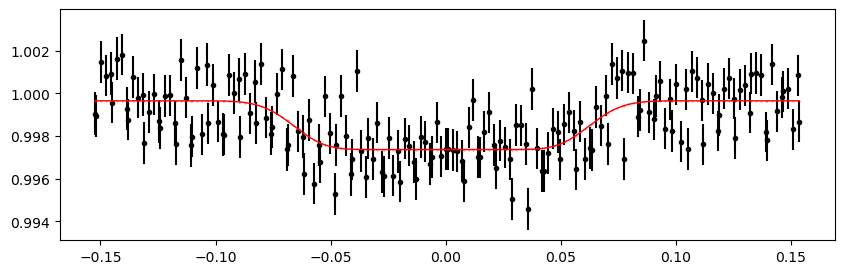

[40, 0.9996512092718723, -0.002284113542051434, -0.0017972024433753578, 0.0023459560190268714]


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.48it/s]


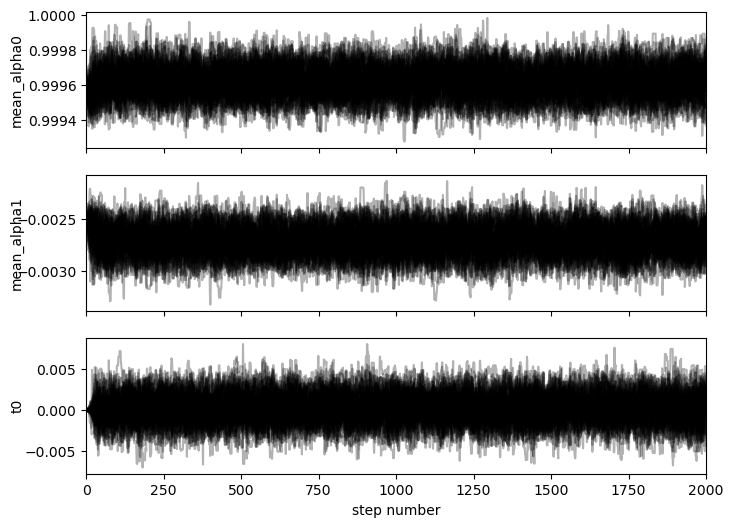

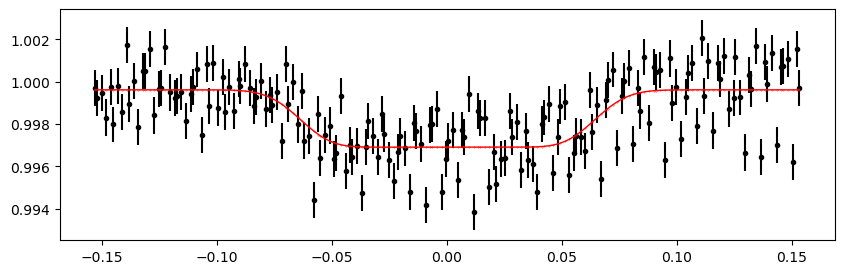

[47, 0.9996195359968894, -0.0027093215093699913, 0.0002483067821088316, 0.0017521829498537945]


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 131.01it/s]


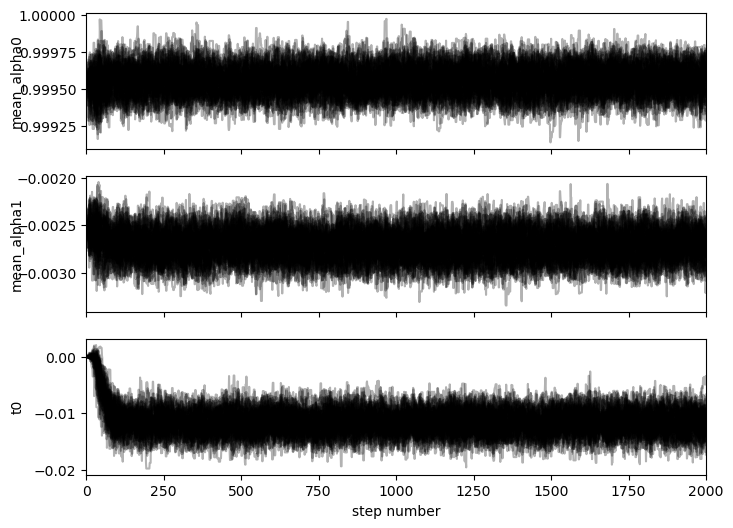

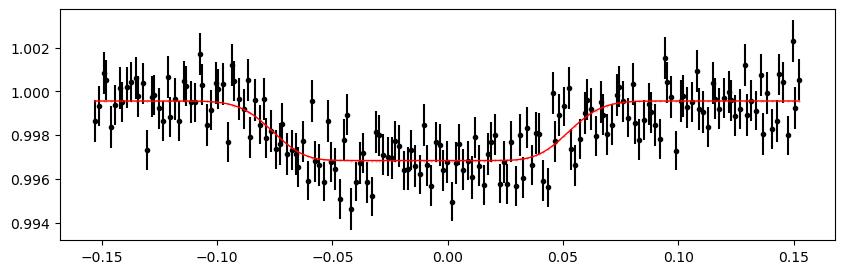

[53, 0.9995615234280669, -0.0027196917982979644, -0.011646718782340734, 0.0020695567150391813]


100%|██████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 86.90it/s]


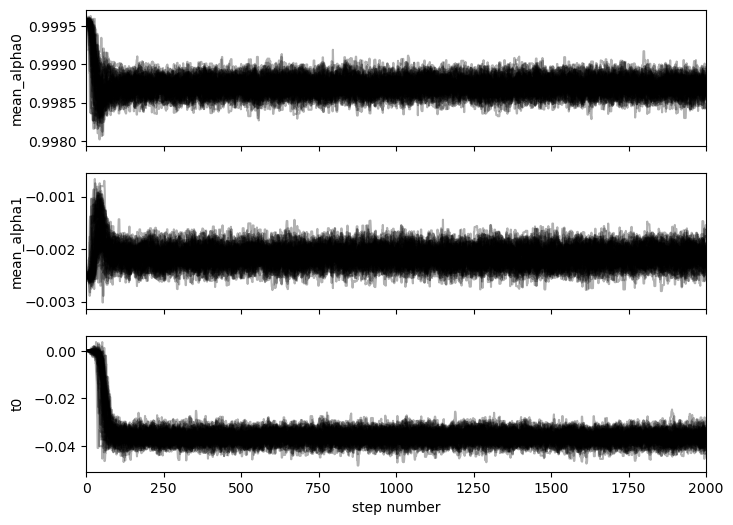

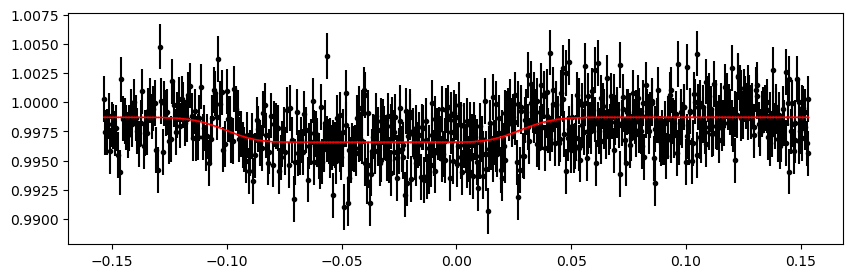

[60, 0.9987184851099967, -0.0021388353397546827, -0.03641446269838305, 0.0026049159801886154]


100%|██████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 96.59it/s]


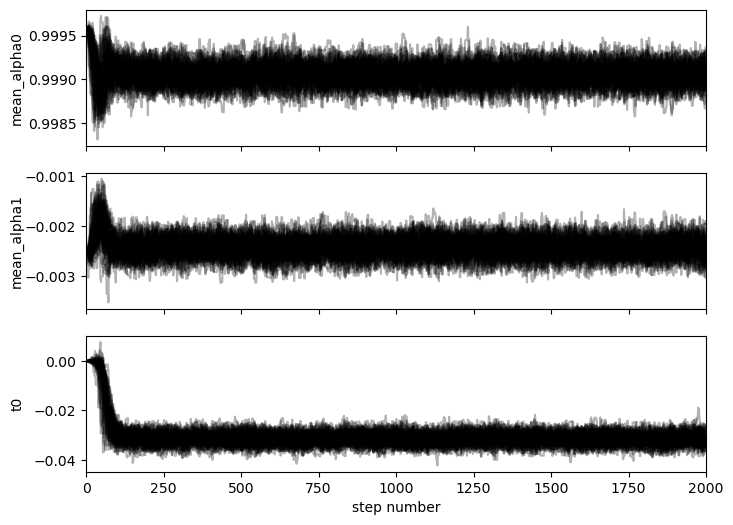

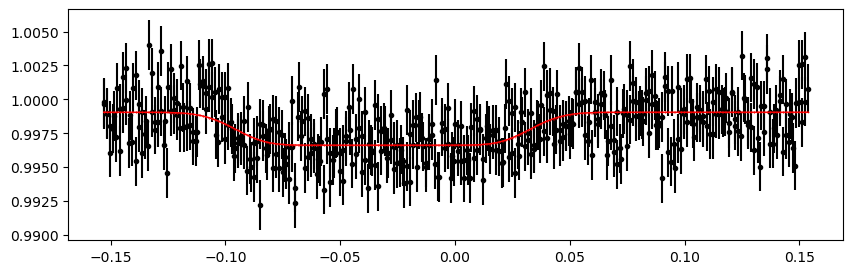

[74, 0.9990551699624016, -0.0024277164319567355, -0.03147852098762237, 0.0024421224410395596]


In [50]:
reload(etv_functions)


# TODO:
# - fold each sector's LC individually
# - for each folded LC, fit alpha0,alpha1,t0  (essentially one loop for fit_each_eclipse())
#   - tenatively named run_mcmc_individual_fit()
# -  plot the result as O-C

fitted_params_list = []

for lc in lcc_tess[:]:
    sector = lc.sector
    lc = lc.remove_nans().normalize()
    lc_f = lc.fold(period=a_spec['period'], epoch_time=a_spec['epoch'])
    lc_f = lc_f.truncate(0 - a_spec['duration_hr'] / 24 * 1.1, 0 + a_spec['duration_hr'] / 24 * 1.1)  # larger truncated window to accomodate shift in t0

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    fitted_params = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau],  
        # nruns=10000, discard=1000,
        nruns=2000, discard=1000,
        # nruns=20, discard=1,
        pool=-2, 
        plot_chains=True,
        plot=True, 
    )
    # [alpha0, alpha1, t0, stdv_t0] =  fitted_params
    fitted_params = [sector] + fitted_params  # include sector as a proxy of epoch
    fitted_params_list.append(fitted_params)
    print(fitted_params)

,sector,alpha0,alpha1,t0,stdv_t0,t0_min,stdv_t0_min
0,26,1.000580,-0.002501,-0.037804,0.002864,-54.437887,4.123843
1,40,0.999651,-0.002284,-0.001797,0.002346,-2.587972,3.378177
2,47,0.999620,-0.002709,0.000248,0.001752,0.357562,2.523143
3,53,0.999562,-0.002720,-0.011647,0.002070,-16.771275,2.980162
4,60,0.998718,-0.002139,-0.036414,0.002605,-52.436826,3.751079
5,74,0.999055,-0.002428,-0.031479,0.002442,-45.329070,3.516656


Text(0.5, 1.0, 'TTV for TIC 99654378 pl 1')

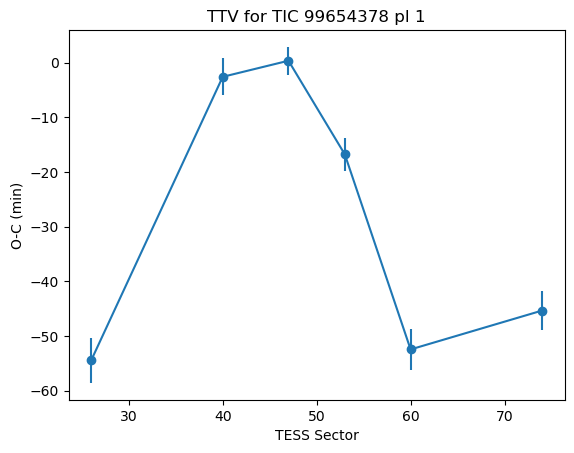

In [63]:
import pandas as pd

c_sector, c_alpha0, c_alpha1, c_t0, c_stdv_t0 = [], [], [], [], []

for fitted_params in fitted_params_list:
    sector, alpha0, alpha1, t0, stdv_t0 = fitted_params
    c_sector.append(sector), c_alpha0.append(alpha0), c_alpha1.append(alpha1), c_t0.append(t0), c_stdv_t0.append(stdv_t0)

df_fitted_params = pd.DataFrame(dict(sector=c_sector, alpha0=c_alpha0, alpha1=c_alpha1, t0=c_t0, stdv_t0= c_stdv_t0))

df_fitted_params["t0_min"] = df_fitted_params.t0 * 24 * 60
df_fitted_params["stdv_t0_min"] = df_fitted_params.stdv_t0 * 24 * 60

display(df_fitted_params)

ax = plt.figure().gca()
ax.errorbar(x=df_fitted_params.sector, y=df_fitted_params.t0_min, yerr=df_fitted_params.stdv_t0_min, marker="o");
ax.set_xlabel("TESS Sector");
ax.set_ylabel("O-C (min)");
ax.set_title(f"""TTV for TIC {tic} {a_spec["label"]}""");